# Applications of LSTM to the Prediction of Stock Market

Date: Febrary 2023 

## 摘要
XXX


## 准备数据集


第一步是获取股票数据，并将其加载到内存中。我们将从 Yahoo Finance 获取股票数据。Yahoo Finance 是一个丰富的金融市场数据和工具资源，我们可以使用 yfinance 库来从该网站下载股票数据。

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 58.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import yfinance as yf
# For time stamps
from datetime import datetime
import pandas as pd
import numpy as np

# as an example, we'll use 'Google' for this analysis
ticker = 'GOOG'

# three years
end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

# download data from Yahoo Finance
stock_data = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


为了方便之后的数据获取，我们将其封装为一个函数

In [3]:
def get_data_yahoo(ticker, years):
  end = datetime.now()
  start = datetime(end.year - years, end.month, end.day)
  stock_data = yf.download(ticker, start, end)
  return stock_data

## 数据分析

In [4]:
# print last 15 records
print(stock_data.tail(15))

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-30   98.745003   99.408997   97.519997   97.949997   97.949997   
2023-01-31   97.860001   99.910004   97.790001   99.870003   99.870003   
2023-02-01   99.739998  102.190002   98.419998  101.430000  101.430000   
2023-02-02  106.790001  108.820000  106.540001  108.800003  108.800003   
2023-02-03  103.510002  108.019997  103.300003  105.220001  105.220001   
2023-02-06  102.684998  104.699997  102.209999  103.470001  103.470001   
2023-02-07  103.629997  108.669998  103.547997  108.040001  108.040001   
2023-02-08  102.690002  103.580002   98.455002  100.000000  100.000000   
2023-02-09  100.540001  100.610001   93.860001   95.459999   95.459999   
2023-02-10   95.739998   97.019997   94.529999   94.860001   94.860001   
2023-02-13   95.010002   95.349998   94.050003   95.000000   95.000000   
2023-02-14   94.660004   95.175003   9


观察打印出来的数据，我们可以发现日期是数据的索引。其他几列的含义如下：
* Open - 当日股票开盘时的价格
* High - 当日股票的最高价格
* Low - 当日股票的最低价格
* Close - 当日收盘时的价格
* Adj Close - 调整后的收盘价
* Volume - 当日股票成交量  

另外，注意到记录中缺少周末的数据，这也符合股市的规则。

### 描述性统计信息

DataFrame 支持使用 describe() 生成描述性统计信息。描述性统计包括汇总数据集分布的中心趋势、分散度和形状的统计，不包括NaN值。

In [5]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,105.849598,107.140125,104.630873,105.894098,105.894098,3.063571e+07
std,26.097107,26.171685,25.918265,26.027693,26.027693,1.347901e+07
min,52.825500,53.566002,50.676800,52.831001,52.831001,6.936000e+06
25%,86.678625,87.740376,85.880751,86.768623,86.768623,2.185300e+07
50%,104.381248,106.138676,103.523998,104.915001,104.915001,2.724200e+07
75%,129.871372,130.934311,127.521626,129.243504,129.243504,3.512000e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,9.779860e+07


可以发现，过去三年仅有 756 天的股票数据，这是由于周末是没有数据记录的。另外还可以发现，该股票的股价过去一年在[50.676800, 152.100006] 这个区间波动

同样的，我们还可以使用 info() 来获取 DataFrame 的数据信息

In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-02-20 to 2023-02-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


### 收盘价


收盘价是股票在正常交易日的最后交易的价格，往往股票的收盘价会被投资者用做跟踪其长期表现的标准基准。因此，我们需要重点关注收盘价(通常关注调整后的收盘价)。

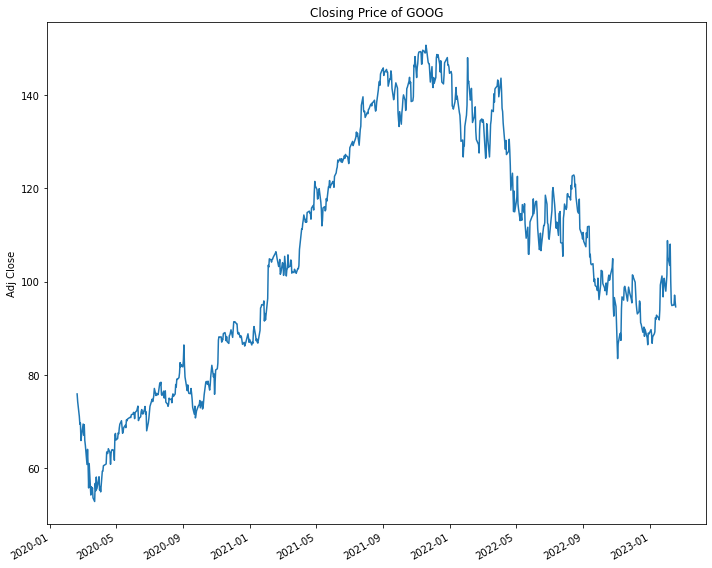

In [7]:
import matplotlib.pyplot as plt

# see a historical view of the closing price
plt.figure(figsize=(10, 8))

stock_data['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of {ticker}")
    
plt.tight_layout()

### 成交量

股票交易量是指每日开盘和收盘之间交易的股票数量。交易量以及交易量随时间的变化是股票技术交易者以及广大股民的重要参考指标。

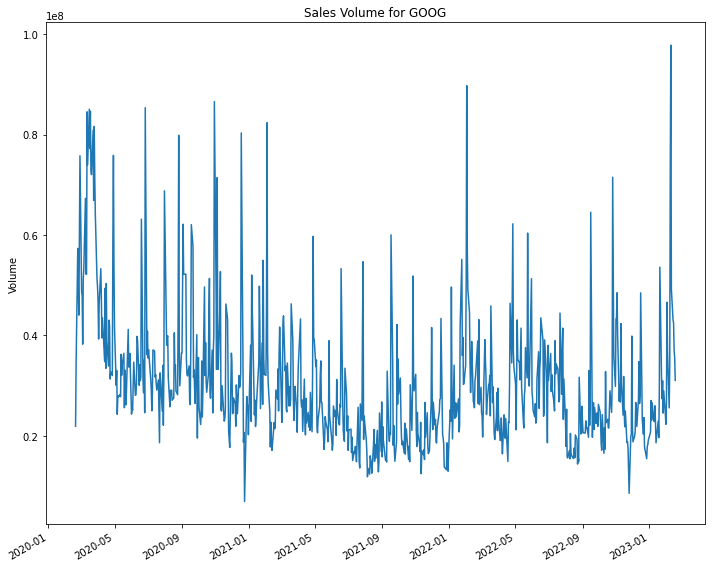

In [8]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(10, 8))

stock_data['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume for {ticker}")
    
plt.tight_layout()

可以看出，在2020-05 到 2021-09 期间，谷歌的股价经历了持续不小幅度的上涨。在2022-01 到 2023-01 期间，股票价格持续有所下跌。

### 平均移动线

移动平均线（MA）是一种简单的技术分析工具，通过创建不断更新的平均价格来平滑价格数据。平均值是在特定的时间段内得出的，例如10分钟、20分钟、30分钟或交易者选择的任何时间段。

<Figure size 1440x1080 with 0 Axes>

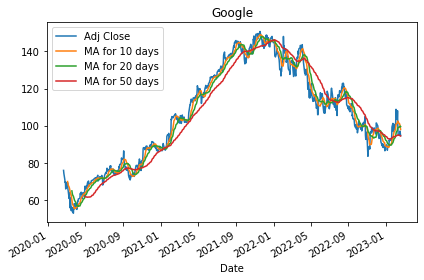

In [9]:
ma_day = [10, 20, 50]

for ma in ma_day:
  column_name = f"MA for {ma} days"
  stock_data[column_name] = stock_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(20, 15)) 
stock_data[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("Google")

plt.tight_layout()

我们在图中看到，测量移动平均线的最佳值是10天和20天，而50天的 MA 和收盘价拟合的效果明显差很多。这是由于10天和20天的MA噪声很少，相对50天而言，仍然是在较少噪声的情况下捕捉数据中的趋势，因此和收盘价高度拟合。

### 每日收益

前面我们已经做了一些基础的数据分析，接下来需要分析购买股票的风险。  
为了做到这一点，我们需要更仔细地观察股票的每日变化，而不仅仅是它的绝对价值。因此，我们关注Google的每日收益

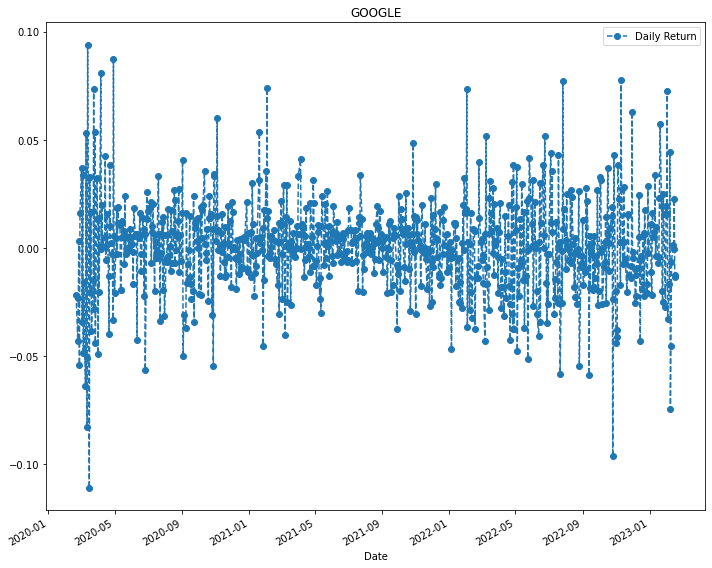

In [10]:
# plot the daily return percentage
plt.figure(figsize=(10, 8)) 

stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()
stock_data['Daily Return'].plot(legend=True, linestyle='--', marker='o')

plt.title('GOOGLE')
plt.tight_layout()

## 模型训练

### 数据集划分 & 预处理

我们还是以 Google 的股票为例，来展示我们的模型效果。同时我们会将其封装好，只需要改变股票的名称，就可以重训练，从而无需对每个不同的股票都重新编码。  
我们使用前面封装好的获取数据集的接口来拿到 Google 过去 10 年的数据。

In [11]:
stock_data = get_data_yahoo("GOOG", 10)
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2013-02-20  20.057320  20.148727  19.720831  19.737518  19.737518  110982436
2013-02-21  19.875502  20.061056  19.706635  19.813982  19.813982  140781714
2013-02-22  19.906883  19.956448  19.770893  19.918093  19.918093   82463941
2013-02-25  19.982599  20.134781  19.688454  19.695427  19.695427   92501423
2013-02-26  19.800781  19.824444  19.536772  19.679485  19.679485   88430220


通过作图，可以大致看出 Google 过去 10 年的股价变化趋势

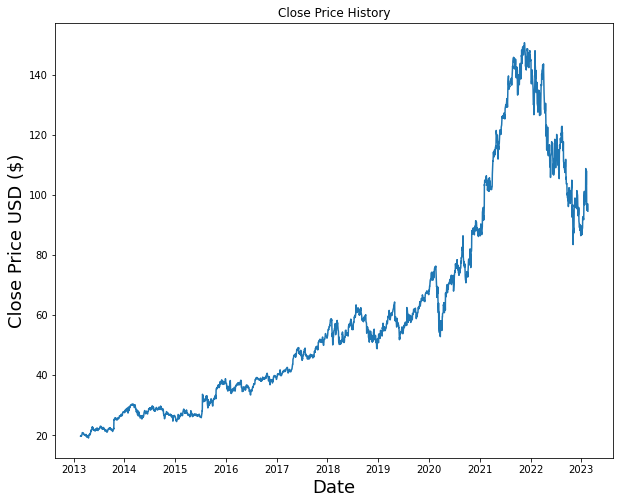

In [12]:
plt.figure(figsize=(10, 8))
plt.title('Close Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

为了之后的模型训练，我们需要将这 10 年的数据划分为 训练集和测试集。另外，根据前面的数据分析，我们认为仅需考虑收盘价格即可。

In [20]:
# Create a new dataframe with only the 'Close column 
data = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
print(len(dataset))
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * 0.9))

2518


接下来，我们需要对数据进行简单的预处理，这里选择对其进行 MinMax 操作，放缩到[0,1]之间

In [21]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[0.0050236 ]
 [0.00560449]
 [0.0063954 ]
 ...
 [0.59273813]
 [0.58271023]
 [0.57366991]]


最后，我们准备好训练集和测试集，以供之后的模型进行学习训练

In [33]:
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
# choose 30 for MA
MA = 30
for i in range(MA, len(train_data)):
    x_train.append(train_data[i-MA:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - MA: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(MA, len(test_data)):
    x_test.append(test_data[i-MA:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

### Loss Function MSE

MSE(mean squared error) 均方误差是各数据偏离真实值差值的平方和 的平均数，也就是误差平方和的平均数。  
MSE 是 ML 回归模型（例如线性回归）中常用的统计度量和损失函数，因此这里预测股票价格选择 MSE 作为损失函数是合理的。

$ MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_i - \hat{Y_i})^2 $  

### Optimizer Adam

Adam是一个直觉上很简洁，但理论上很难理解的优化器。Adam自从在ICLR2015上发表以来（ Adam: A Method for Stochastic Optimization ），到2022年就已经收获了超过10万次引用，正在成为深度学习时代最有影响力的几个工作之一。

简单来说，Adam = Momentum + Adaptive Learning Rate  
* Momentum实际上就用过去梯度的moving average来更新参数。
* Adaptive Learning Rate则是利用过去梯度信息来确定各个方向的学习率的大小——loss landscape越平坦的方向用越大的学习率来更新模型参数

一般来说，Adam收敛速度更快，但最终的结果却并不好。由于前面我们限制了不使用 GPU，而 使用 CPU 进行深度学习模型的训练和推理是十分缓慢的。因此这里还是选择了 Adam 作为优化器。

### CNN Model

In [52]:
epochs = 20
batchSize = 1000
nOutput = 1
kernelSize = 1

In [51]:
# Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batchSize, verbose=1)

Epoch 1/20


ValueError: ignored

In [45]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

8/8 [==============================] - 0s 4ms/step
10.639150124994265


251


<ipython-input-46-9826a1cec057>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


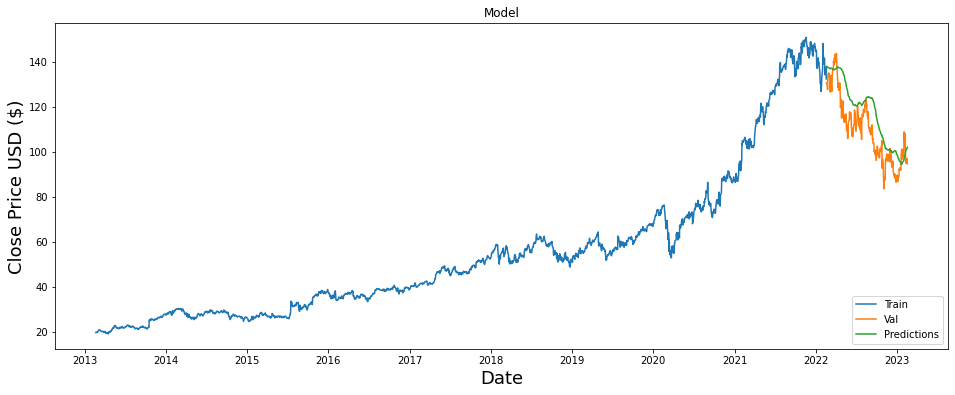

In [46]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### LSTM Model

循环神经网络（Recurrent Neural Network，RNN）是一种用于处理序列数据的神经网络。相比一般的神经网络来说，他能够处理序列变化的数据。比如某个单词的意思会因为上文提到的内容不同而有不同的含义，RNN就能够很好地解决这类问题。  

Long short-term memory - LSTM，是一种特殊的RNN，主要是为了解决长序列训练过程中的梯度消失和梯度爆炸问题。简单来说，就是相比普通的RNN，LSTM能够在更长的序列中有更好的表现。

这里，我们使用 keras，利用 tensorflow 后端来构建 LSTM 模型。

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()

# there are total 2518 days, so 128 will be a nice try
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
# finally, wo must get one predition instead of a tensor
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2237/2237 [==============================] - 36s 14ms/step - loss: 0.0011


In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 128)           66560     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 25)                1625      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

8/8 [==============================] - 1s 13ms/step
4.894993286465715


注意到，最终计算预测值和实际值的 MSE 为 4.89 左右，说明误差已经很小了。

下面我们通过绘图来直观的感受一下预测值和真实结果的拟合情况。

251


<ipython-input-37-9826a1cec057>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


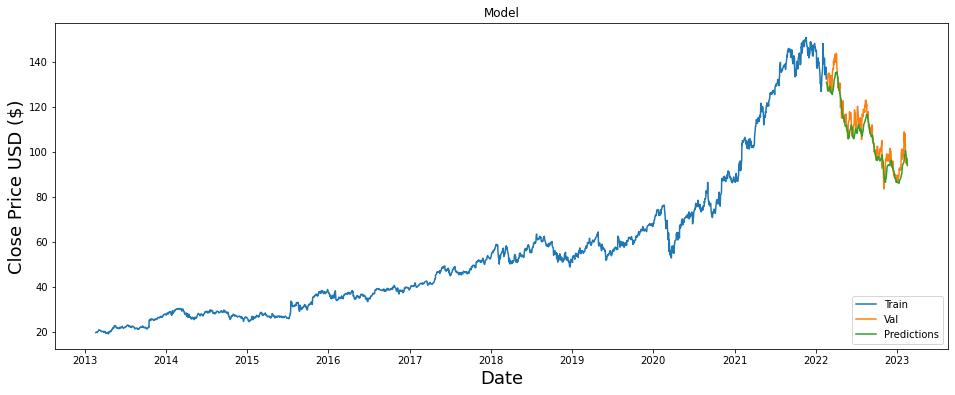

In [37]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## 总结

## Future Work